# Course Project: Determining Quality Pitches

To determine quality pitches, I am using the pybaseball python package to query statcast data based on a specific pitcher. First I filter on player_id and then I evaluate exit velocity, launch angle, and instances where contact was made.

In [16]:
import pybaseball as pyb
import pandas as pd
import numpy as np
#from tabulate import tabulate
import matplotlib.pyplot as plt
%matplotlib inline

## Please Choose A Pitcher You Would Like To Evaluate

In [17]:
pitcherFirst = input("Please enter a pitcher's first name: ")
pitcherLast = input("Please enter a pitcher's last name: ")
pid = pyb.playerid_lookup(pitcherLast,pitcherFirst).iloc[0]['key_mlbam']
pid

#understanding the stats
#launch speed = exit velocity
#release speed = speed of ball released from pitcher
#effective speed = speed of ball crossing the plate
#launch angle = how high in degrees, a ball was hit by a batter.


Please enter a pitcher's first name: chris
Please enter a pitcher's last name: sale
Gathering player lookup table. This may take a moment.


519242

## Find Player Name By MLBAM id

In [83]:
mlb_id = int(input("Please enter the mlbam id to retrieve player name: "))
player_ids = [mlb_id]
data = pyb.playerid_reverse_lookup(player_ids, key_type='mlbam')
data

Please enter the mlbam id to retrieve player name: 596142
Gathering player lookup table. This may take a moment.


,name_last,name_first,key_mlbam,key_retro,key_bbref,key_fangraphs,mlb_played_first,mlb_played_last
0,sanchez,gary,596142,sancg002,sanchga02,11442,2015.0,2018.0


## Load The Data And Create Subset
load the pitcher's statcast data from 4/01/2008 - 7/15/2017 <br>
grab all pitcher's data where there is an exit velocity value<br>
Since loading batter data for each batter this pitcher faces is dependent on how many entries there are, I am creating a subset of x batters the pitcher faces most often.

In [18]:
#Loading the data -- This may take some time
#get pitcher data and filter on exit speed values
spdata = pyb.statcast_pitcher('2008-04-1','2017-07-15', player_id=pid) #chris sale
print("loaded statcast pitcher data for",pitcherFirst,pitcherLast)
spdata = spdata[spdata.launch_speed != 'null']

#inform user and get user input
bat_ids,counts = np.unique(np.array(spdata['batter']),return_counts=True)
print("There are",len(bat_ids),"batters this pitcher faces where a launch speed is recorded")
top = int(input("How many of the most common batters would you like to observe? "))

#printing out counts pitcher faces each batter and subset of batters
print("How often each batter occurs:")
print(np.sort(counts))
print("subset of",top,"most frequent batters: ")
print(np.sort(counts)[-top:])
cutoff = np.sort(counts)[len(bat_ids)-top]
bat_EV = []
batters = []

#create a subset of the x most frequent batters
for i,ids in enumerate(bat_ids):
    if counts[i] >= cutoff: batters.append(ids)

for num, batter in enumerate(batters):
    print("evaluating batter",num,"/",len(batters))
    bat_dat = pyb.statcast_batter('2008-04-01','2017-07-15',player_id=batter)
    #filter on batters exit velocity
    bat_ev = bat_dat[bat_dat.launch_speed != 'null']
    #exclude all the times this batter faced this pitcher
    bat_ev = bat_ev[bat_ev.pitcher == pid]
    if len(bat_ev) == 0:
        bat_EV.append(0)
    else:
        ev_avg = sum(bat_ev['launch_speed'].values.astype(float))/len(bat_ev)
        bat_EV.append(ev_avg)
        #print("batter EV",bat_EV)
    
# print(spdata.shape)
print("completed loading the data")

loaded statcast pitcher data for chris sale
There are 323 batters this pitcher faces where a launch speed is recorded
How many of the most common batters would you like to observe? 25
How often each batter occurs:
[ 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  3  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4
  4  4  4  4  4  4  4  4  4  4  4  4  4  5  5  5  5  5  5  5  5  5  5  5  5
  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  6  6  6  6  6  6
  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  7  7  7  7  7  7  7  7
  7  7  7  8  8  8  8  8  8  8  8  8  8  8  8  8  8  9  9  9  9  9  9  9  9
  9  9  9  9  9  9  9  9  

/home/callie/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2802: DtypeWarning: Columns (2,14,27,28,29,30,44,45,46,47,48,49,50,51) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


evaluating batter 17 / 25
evaluating batter 18 / 25
evaluating batter 19 / 25
evaluating batter 20 / 25
evaluating batter 21 / 25
evaluating batter 22 / 25
evaluating batter 23 / 25
evaluating batter 24 / 25
completed loading the data


## Calculating a Rough Theoretical Exit Velocity

This theoretical exit velocity will be used to compare against the actual exit velocity to evaluate how well a pitcher is able to suppress a hitter's exit velocity and overall prevent a hit. After researching different methods of calculating exit velocity, I decided to test out a couple different equations including one from [Dr. Nathan's analysis](http://baseball.physics.illinois.edu/AJP-Feb2003.pdf) of the ball bat collision. Another reference I found extremely helpful was the [FanGraphs community research](https://www.fangraphs.com/community/reverse-engineering-swing-mechanics-from-statcast-data/) article that detailed how to extract a hitter's swing speed from statcast data.<br><br>
Dr. Nathan's equation is $V_{ball exit} = e_A \cdot V_{ball}+(1+e_A) \cdot V_{bat}$ where <br>
$V_{ball exit} = $ speed of the ball as it leaves the bat <br> $V_{ball} = $ speed of ball as it leaves the bat <br> $V_{pitch} = $ speed of the pitch of the ball right before it hits the bat<br> $e_A = $ collision efficiency<br><br>
To account for the unknown swing speed in this equation, I decided to use this equation to average a hitter's swing speed by using the actual exit velocity in all other instances this hitter hit the ball.<br><br>
My original equation roughly estimates the exit velocity knowing the distance of how far the ball traveled and the angle at which it was launched. This estimate does not account for swing speed, air resistance, drag,or energy absorbed by the bat. This equation was in some cases extremely close to the actual exit velocity but in almost all cases was always less than the actual exit velocity (which would make sense since a ball with resistance would need to travel at a faster rate to reach the same distance as a ball with no resistance).<br><br>
$EV = \sqrt{g \cdot \frac{d}{sin{2\theta}}}$ where <br>
$g = 9.81$<br> $d =$ distance the ball traveled<br> $\theta =$ launch angle<br><br>
I also created a theoretical exit velocity from the hitter's exit velocity against other pitcher. So the exit velocity this hitter typically achieves compared to the exit velocity achieved against the specified pitcher. This also posed some challenges because for example Chris Sale played against 564 unique batters and to query each batter to get their average exit velocities would have taken approximately 56 minutes. I also considered only looking at a subset of this data where the batter played against Chris Sale in this case greater than 80 times.

## Calculate Pitcher's Suppression Statistic For Each Batter of the Subset


In [19]:
#filter pitcher data to only compare batters of the batter subset
sub = dict(zip(list(batters),list(bat_EV)))
sub_pit = spdata[spdata.batter.isin(batters)]

#create a dataframe of batter ids and their expected exit velocity for each batter in pitcher subset
t = pd.DataFrame({ 'batter':sub_pit.batter,'expEV': [sub[x] for x in sub_pit.batter.values]})

#add batter expEV
sub_pit.insert(loc=0, column='expEV', value=t.expEV)
#remove values where batter has a 0 for expEV (this was a filler value)
sub_pit = sub_pit[sub_pit.expEV != 0]

#calculate suppression stat for each batter the pitcher faces
sub_pit.insert(loc=0, column='suppression', value=sub_pit.expEV - sub_pit.launch_speed.values.astype(float))
err = abs(sub_pit.expEV - sub_pit.launch_speed.values.astype(float))/sub_pit.launch_speed.values.astype(float)
sub_pit.insert(loc=0, column='supErr', value=err*100)

display(sub_pit[['batter','expEV','launch_speed','suppression','supErr']])
avg_ev = sum(sub_pit.launch_speed.values.astype(float))/len(sub_pit.launch_speed.values)
avg_sup = sum(sub_pit.suppression.values.astype(float))/len(sub_pit.suppression.values)
avg_supr = sum(sub_pit.supErr.values.astype(float))/len(sub_pit.supErr.values)
print("On average this pitcher suppressed exit velocity by",round(avg_supr,2),"%")
print("avg exit velocity",avg_ev)


,batter,expEV,launch_speed,suppression,supErr
144,446334,84.820000,80.0,4.820000,6.025000
145,461858,81.345455,86.5,-5.154545,5.959012
147,461858,81.345455,61.1,20.245455,33.134950
176,461858,81.345455,67.5,13.845455,20.511785
178,461858,81.345455,74.8,6.545455,8.750608
222,461858,81.345455,80.8,0.545455,0.675068
241,607680,80.261905,96.8,-16.538095,17.084809
277,607680,80.261905,80.0,0.261905,0.327381
278,607680,80.261905,61.7,18.561905,30.084124
279,607680,80.261905,74.4,5.861905,7.878904


On average this pitcher suppressed exit velocity by 14.92 %
avg exit velocity 84.0387788779


## Analyze Suppression Stat Results

This stat seems to be a good comparison of how well a pitcher suppresses exit velocity. By looking at how well a batter performs against all other pitchers and how well the batter performs against this pitcher gives an indication of a pitcher's exit velocity suppression ability compared to other pitchers. Since exit velocity is mostly due to batter performance, I examine exit velocities by each batter's ability to better account for pitcher performance. I considered averaging all exit velocities for each pitcher but I believe this gives a better representation since all batter's perform differently and this way the suppression stat depends more on how the batter performs on average compared to this pitcher.


33.1 112.3


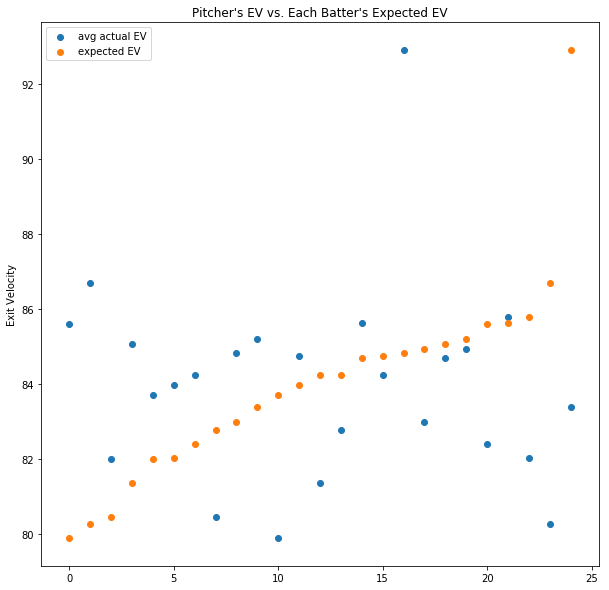

In [15]:

m1 = min(sub_pit.launch_speed.values.astype(float))
m2 = min(sub_pit.expEV.values.astype(float))
ma1 = max(sub_pit.launch_speed.values.astype(float))
ma2 = max(sub_pit.expEV.values.astype(float))
xm = min([m1,m2])
xma = max([ma1,ma2])
print(xm,xma)
avg_evs = []
for bid in np.unique(sub_pit.batter):
    evs = sub_pit[sub_pit.batter == bid].launch_speed.values.astype(float)
    avg_evs.append(np.mean(evs))
#print(avg_evs,len(avg_evs))
#print(len(np.unique(sub_pit.expEV.values.astype(float))))

fig,ax = plt.subplots(sharex=True,figsize=(10,10))
#x = np.linspace(xm,xma,len(sub_pit.launch_speed.values))
#ax.scatter(x,sub_pit.launch_speed.values.astype(float),label='actual EV')
x = np.arange(len(avg_evs))
#print(len(x),len(avg_evs),len(np.unique(sub_pit.expEV.values.astype(float))))

ax.scatter(x,avg_evs,label='avg actual EV')
ax.scatter(x,np.unique(sub_pit.expEV.values.astype(float)),label='expected EV')
ax.legend()
ax.set_title('Pitcher\'s EV vs. Each Batter\'s Expected EV')
ax.set_ylabel('Exit Velocity')
plt.show()


    

The higher the suppression rate, the better the pitcher is at suppressing exit velocity.

In [ ]:
#https://baseballwithr.wordpress.com/2017/08/07/launch-speed-and-pitch-location/
#http://m.mlb.com/glossary/statcast
#http://www.ecapitaladvisors.com/blog/cognos-analytics-11-mlb-evolution-swing/
#http://www.acs.psu.edu/drussell/bats/besr/BESRWhitePaper.pdf